## 循环神经网络简洁实现

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## 定义模型

In [42]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

## 使用张量来初始化隐藏状态

In [32]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

## 通过一个隐藏状态和一个输入，我们就可以是用更新后的隐藏状态计算输出

In [43]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
# 第一个维度是时间序列维度
# 这个是三维的，我们的从零实现是二维的
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

## 我们为一个完整的循环神经网络模型定义了一个```RNNModel```类

In [44]:
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        if not self.rnn.bidirectional:
            self.num_directions = 1
            # Torch 的RNN模型没有包含输出层，所以需要我们再额外加一个
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens*2, self.vocab_size)
    
    def forward(self, inputs, state):
        # print('hello')
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        # 时间步数*批量大小*隐藏大小
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。        
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state
    
    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

## 基于一个具有随机权重的模型进行预测

In [45]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller ', 10, net, vocab, device)

'time traveller hhhhhhhhhh'

## 使用高级API训练模型

perplexity 1.3, 944292.8 tokens/sec on cuda:0
time travellerit s against reason smighty s ig tomever cour dowe
travelleryou can show blackeit on a munt a orie is an andim


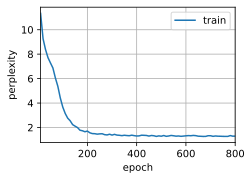

In [46]:
num_epochs, lr = 800, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)